# 06. Transfer learning

Reference Video: https://www.udemy.com/course/pytorch-for-deep-learning/learn/lecture/32854180#overview

Reference Book: https://www.learnpytorch.io/06_pytorch_transfer_learning/

Extra curricular Reference: [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html)

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
from going_modular import data_setup, engine, utils

/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


### Load the dataset

In [4]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Create data loaders

In [5]:
from torchvision import datasets, transforms
import os

##########
# OLD - manually create transforms

# # Values are from ImageNet
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

# # Create simple transform
# data_transform = transforms.Compose([ 
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     normalize
# ])

#############

#############
# NEW - pytorch automatically selects the transform based on the pre-trained model
# Basically tranform the same way as the pretrained model was trained

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # defaults to imagenet IMAGENET1K_V1

auto_transform = weights.transforms() # returns a transform.Compose object
print(f'auto_transform: {auto_transform}')

auto_transform: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [6]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                              test_dir=test_dir,
                              transform=auto_transform,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

print(f"train_dataloader: {train_dataloader}")
print(f"test_dataloader: {test_dataloader}")
print(f"class_names: {class_names}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f8628d27e10>
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f8629718510>
class_names: ['pizza', 'steak', 'sushi']


### Setting up pretrained model

We are using EfficientNet B0 model

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Print model summary

In [8]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential: 2-2  

### Transfer learning - Freeze all layers except the last one

In [9]:
for params in model.features.parameters(): # we want to freeze entire feature extractor
    params.requires_grad = False

In [10]:
# Check the classifier for reference
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [11]:
# Update the classifier head 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names)),
).to(device)

In [12]:
# Check the classifier for reference
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [13]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

### Train model

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [15]:
from going_modular import engine, utils

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

EPOCHS = 10

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

end_time = timer()
print(f"Time elapsed: {end_time - start_time:.3f} seconds")


# Save model
utils.save_model(model=model, target_dir="models", model_name="06_transfer_learning.pth")

 10%|█         | 1/10 [00:03<00:27,  3.03s/it]

Epoch: 1 | train_loss: 1.0681 | train_acc: 0.4297 | test_loss: 0.8688 | test_acc: 0.6714


 20%|██        | 2/10 [00:05<00:22,  2.79s/it]

Epoch: 2 | train_loss: 0.8423 | train_acc: 0.8516 | test_loss: 0.7826 | test_acc: 0.7633


 30%|███       | 3/10 [00:08<00:19,  2.76s/it]

Epoch: 3 | train_loss: 0.7516 | train_acc: 0.8320 | test_loss: 0.7316 | test_acc: 0.7746


 40%|████      | 4/10 [00:11<00:16,  2.73s/it]

Epoch: 4 | train_loss: 0.7009 | train_acc: 0.7969 | test_loss: 0.6373 | test_acc: 0.7841


 50%|█████     | 5/10 [00:13<00:13,  2.76s/it]

Epoch: 5 | train_loss: 0.6123 | train_acc: 0.8047 | test_loss: 0.6256 | test_acc: 0.8456


 60%|██████    | 6/10 [00:16<00:11,  2.79s/it]

Epoch: 6 | train_loss: 0.5432 | train_acc: 0.9297 | test_loss: 0.5789 | test_acc: 0.8153


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

Epoch: 7 | train_loss: 0.5014 | train_acc: 0.9297 | test_loss: 0.5470 | test_acc: 0.7945


 80%|████████  | 8/10 [00:22<00:05,  2.78s/it]

Epoch: 8 | train_loss: 0.4989 | train_acc: 0.8320 | test_loss: 0.5337 | test_acc: 0.8561


 90%|█████████ | 9/10 [00:25<00:02,  2.76s/it]

Epoch: 9 | train_loss: 0.5474 | train_acc: 0.8086 | test_loss: 0.5083 | test_acc: 0.8258


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]

Epoch: 10 | train_loss: 0.4588 | train_acc: 0.8281 | test_loss: 0.4432 | test_acc: 0.9167
Time elapsed: 27.812 seconds
[INFO] Saving model to: models/06_transfer_learning.pth


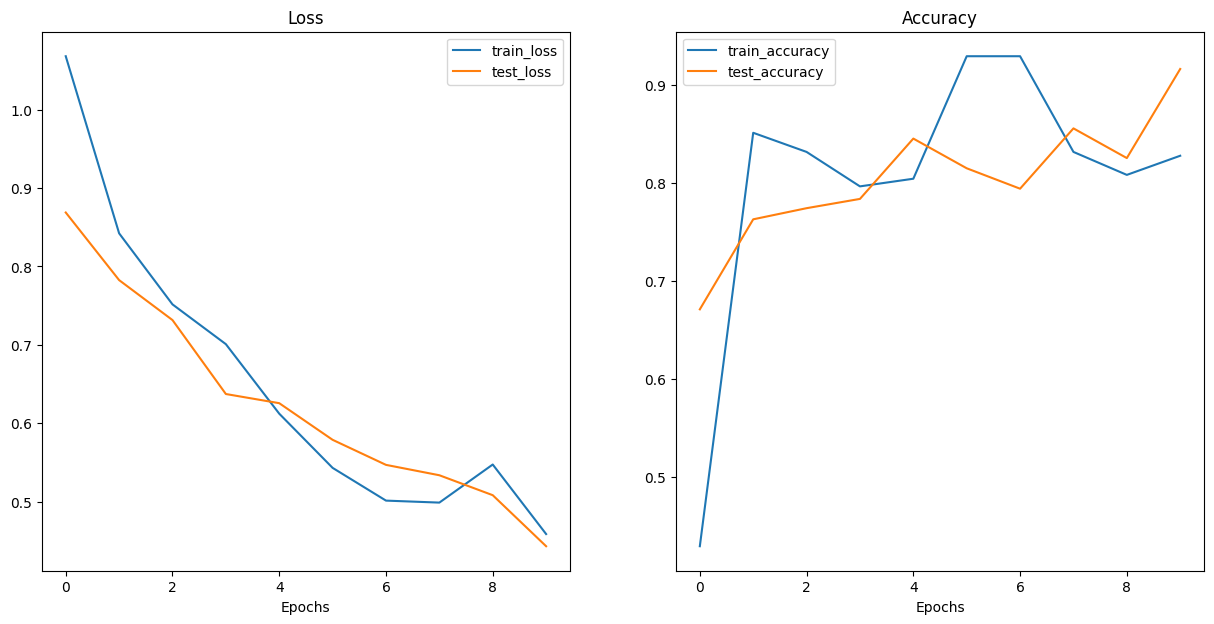

In [16]:
# Evaluation
from helper_functions import plot_loss_curves

plot_loss_curves(results=results)

In [17]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_img(model,
                      img_path,
                      class_names,
                      img_size,
                      transform,
                      device):
    img = Image.open(img_path)

    if transform is not None:
        img_transform = transform
    else:
        img_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    model.to(device)

    model.eval()
    
    with torch.inference_mode():
        img_tensor = img_transform(img).unsqueeze(0)
        img_tensor = img_tensor.to(device)
        prediction = model(img_tensor)

    pred_probs = torch.softmax(prediction, dim=1)
    pred_class = torch.argmax(pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred_class]} | Prob: {pred_probs.max():.3f}")


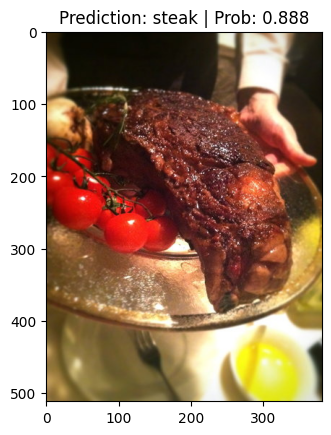

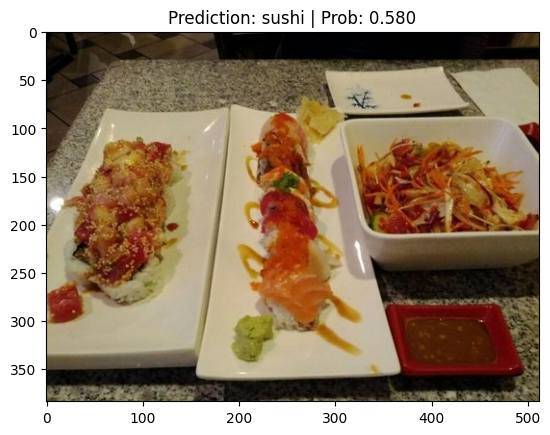

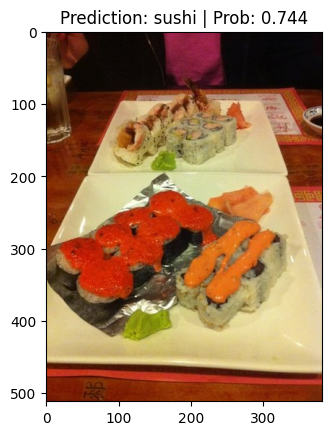

In [18]:

import random

num_imgs = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_path_sample = random.sample(population=test_img_path_list, k=num_imgs)

for test_img in test_img_path_sample:
    pred_and_plot_img(model=model,
                    img_path=test_img,
                    class_names=class_names,
                    img_size=(224, 224),
                    transform=auto_transform,
                    device=device)

### Benchmark on Test dataset

In [27]:
def evaluate_model(model,
                   dataloader,
                   device):
    
    model.eval()

    test_accuracy = 0

    for batch, (X, y) in enumerate(dataloader):
        with torch.inference_mode():
            prediction = model(X.to(device)).to(device)
            test_accuracy += ((prediction.argmax(dim=1) == y.to(device)).sum().item())

    print(f"Test accuracy: {test_accuracy/len(dataloader) * 100:.2f} %")

In [28]:
from pathlib import Path
from torchvision import datasets, transforms
from going_modular import model_builder
import torch
import matplotlib.pyplot as plt

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

test_dir = image_path / "test"

# Create simple transform
data_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                             batch_size=1,
                                             shuffle=False)

# Get class names as a list
class_names = test_data.classes

# Can also get class names as a dict
class_dict = test_data.class_to_idx

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the model architecture
model = torchvision.models.efficientnet_b0().to(device)
# Update the classifier head 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names)),
).to(device)

# load the model weights
weights_file = "models/06_transfer_learning.pth"
model.load_state_dict(torch.load(weights_file))

evaluate_model(model=model, dataloader=test_dataloader, device=device)



Test accuracy: 85.33 %
